<a href="https://colab.research.google.com/github/oscarclivio/DL_S1_MVA_Homework/blob/master/OC_Proj1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - Image Classification and Regression - Deep Learning - S1 MVA

Oscar Clivio

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
import keras

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import regularizers

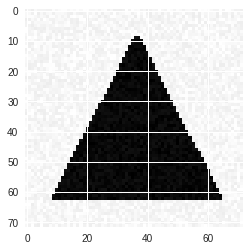

In [89]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



In [0]:
def visualize_prediction(x, y, num_rows=1, num_cols=1):
    fig, ax = plt.subplots(figsize=(15, 15),nrows=num_rows,ncols=num_cols)
    
    indices = np.random.randint(0, y.shape[0], size=num_rows*num_cols)
    
    ind = 0
    
    for row in range(num_rows):
        for col in range(num_cols):
          
            I = x[indices[ind]].reshape((IMAGE_SIZE,IMAGE_SIZE))
            ax[row,col].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
            
            ax[row,col].set_xlim([0,1])
            ax[row,col].set_ylim([0,1])
            
            xy = y[indices[ind]].reshape(3,2)
            tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
            ax[row,col].add_patch(tri)
            
            ind += 1
            
    plt.show()

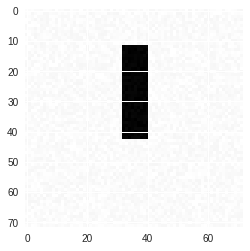

In [5]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

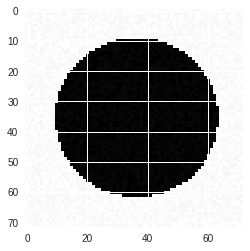

In [6]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

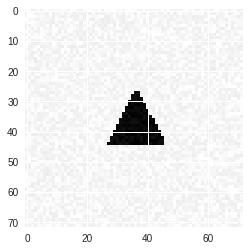

In [7]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Simple Classification

**Comment : ** here we use a linear classifier (ie Dense module with a softmax activation) with a stochastic gradient descent optimizer and an Adam optimizer, and we train them with 300 examples and 100 networks. Then we test the trained classifiers on a test disk. Although both simulations are very unstable with respect to that test, the Adam classifier usually yields more successes on that test than the SGD classifier.

In [90]:
# Create data and SGD optimize

[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3)

sgd = SGD(lr=1e-4)

Creating data:
0
100
200


In [91]:
model = Sequential([Dense(3, input_shape=(5184,), activation='softmax')])


model.compile(loss='categorical_crossentropy',optimizer=sgd)
model.fit(X_train, Y_train, epochs=100)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print("\n\n\n==== RESULT for a disk (we want [0,1,0]) ====\n\n",model.predict(X_test))

Epoch 1/100
300/300 [==============================] - 1s 4ms/step - loss: 1.2309
Epoch 2/100
300/300 [==============================] - 0s 154us/step - loss: 1.1852
Epoch 3/100
300/300 [==============================] - 0s 164us/step - loss: 1.1630
Epoch 4/100
300/300 [==============================] - 0s 158us/step - loss: 1.1447
Epoch 5/100
300/300 [==============================] - 0s 169us/step - loss: 1.1302
Epoch 6/100
300/300 [==============================] - 0s 166us/step - loss: 1.1139
Epoch 7/100
300/300 [==============================] - 0s 232us/step - loss: 1.0989
Epoch 8/100
300/300 [==============================] - 0s 157us/step - loss: 1.0859
Epoch 9/100
300/300 [==============================] - 0s 165us/step - loss: 1.0678
Epoch 10/100
300/300 [==============================] - 0s 151us/step - loss: 1.0566
Epoch 11/100
300/300 [==============================] - 0s 158us/step - loss: 1.0446
Epoch 12/100
300/300 [==============================] - 0s 167us/step - loss

In [11]:
model = Sequential([Dense(3, input_shape=(5184,), activation='softmax')])


model.compile(loss='categorical_crossentropy',optimizer='Adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print("\n\n\n==== RESULT for a disk (we want [0,1,0]) ====\n\n",model.predict(X_test))

Epoch 1/100
300/300 [==============================] - 0s 660us/step - loss: 1.8090
Epoch 2/100
300/300 [==============================] - 0s 163us/step - loss: 0.9833
Epoch 3/100
300/300 [==============================] - 0s 161us/step - loss: 0.6801
Epoch 4/100
300/300 [==============================] - 0s 227us/step - loss: 0.5592
Epoch 5/100
300/300 [==============================] - 0s 154us/step - loss: 0.4009
Epoch 6/100
300/300 [==============================] - 0s 160us/step - loss: 0.3227
Epoch 7/100
300/300 [==============================] - 0s 166us/step - loss: 0.2841
Epoch 8/100
300/300 [==============================] - 0s 160us/step - loss: 0.2933
Epoch 9/100
300/300 [==============================] - 0s 170us/step - loss: 0.2268
Epoch 10/100
300/300 [==============================] - 0s 160us/step - loss: 0.2152
Epoch 11/100
300/300 [==============================] - 0s 164us/step - loss: 0.2043
Epoch 12/100
300/300 [==============================] - 0s 157us/step - lo

## Visualization of the Solution

** Comment ** : here we note that all weights (one per class) look centered with respect to the middle of the image, which is not surprising as the figures themselves are centered with respect to the same middle.

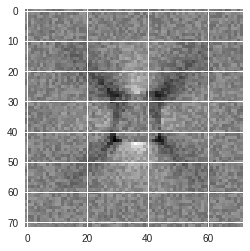

In [12]:
im = model.get_weights()[0][:,0].reshape(IMAGE_SIZE,IMAGE_SIZE)
plt.imshow(im, cmap='gray')

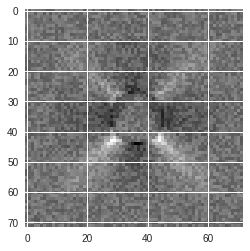

In [13]:
im = model.get_weights()[0][:,1].reshape(IMAGE_SIZE,IMAGE_SIZE)
plt.imshow(im, cmap='gray')

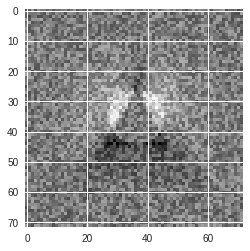

In [14]:
im = model.get_weights()[0][:,2].reshape(IMAGE_SIZE,IMAGE_SIZE)
plt.imshow(im, cmap='gray')

## A More Difficult Classification Problem

### With a linear classifier

**Comment : ** while training the same classifiers as previously with 3000 examples, we obtain around 0.79 for the loss function (categorical cross-entropy) and 0.60 for the accuracy using the SGD classifier, and around 1.1 for the loss function and 0.64 for the accuracy using the Adam classifier. These rather mediocre results may justify the use of a CNN.

In [18]:
# Create data and SGD optimizer

[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3)


sgd = SGD(lr=1e-4)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [19]:
# SGD linear classifier

model = Sequential([Dense(3, input_shape=(5184,), activation='softmax')])


model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100)

[X_test, Y_test] = generate_test_set_classification()
print("\n\n\n==== Score on the test set ====\n\n",model.evaluate(X_test, Y_test))

Epoch 1/100
3000/3000 [==============================] - 1s 216us/step - loss: 1.1939 - acc: 0.3103
Epoch 2/100
3000/3000 [==============================] - 0s 138us/step - loss: 1.1095 - acc: 0.3577
Epoch 3/100
3000/3000 [==============================] - 0s 147us/step - loss: 1.0887 - acc: 0.3867
Epoch 4/100
3000/3000 [==============================] - 0s 143us/step - loss: 1.0711 - acc: 0.4180
Epoch 5/100
3000/3000 [==============================] - 0s 148us/step - loss: 1.0559 - acc: 0.4427
Epoch 6/100
3000/3000 [==============================] - 0s 145us/step - loss: 1.0418 - acc: 0.4540
Epoch 7/100
3000/3000 [==============================] - 0s 136us/step - loss: 1.0296 - acc: 0.4640
Epoch 8/100
3000/3000 [==============================] - 0s 138us/step - loss: 1.0182 - acc: 0.4767
Epoch 9/100
3000/3000 [==============================] - 0s 143us/step - loss: 1.0074 - acc: 0.4847
Epoch 10/100
3000/3000 [==============================] - 0s 136us/step - loss: 0.9981 - acc: 0.4887

In [20]:
# Adam classifier

model = Sequential([Dense(3, input_shape=(5184,), activation='softmax')])


model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, batch_size=32)

[X_test, Y_test] = generate_test_set_classification()
print("\n\n\n==== Score on the test set ====\n\n",model.evaluate(X_test, Y_test))

Epoch 1/100
3000/3000 [==============================] - 1s 245us/step - loss: 1.1672 - acc: 0.4717
Epoch 2/100
3000/3000 [==============================] - 0s 155us/step - loss: 0.9499 - acc: 0.5443
Epoch 3/100
3000/3000 [==============================] - 0s 164us/step - loss: 0.9088 - acc: 0.5633
Epoch 4/100
3000/3000 [==============================] - 0s 155us/step - loss: 0.8614 - acc: 0.5823
Epoch 5/100
3000/3000 [==============================] - 0s 162us/step - loss: 0.9019 - acc: 0.5667
Epoch 6/100
3000/3000 [==============================] - 0s 155us/step - loss: 0.8472 - acc: 0.5990
Epoch 7/100
3000/3000 [==============================] - 0s 160us/step - loss: 0.8879 - acc: 0.5740
Epoch 8/100
3000/3000 [==============================] - 0s 154us/step - loss: 0.8260 - acc: 0.6077
Epoch 9/100
3000/3000 [==============================] - 0s 162us/step - loss: 0.7773 - acc: 0.6170
Epoch 10/100
3000/3000 [==============================] - 0s 156us/step - loss: 0.8269 - acc: 0.6007

### With a CNN

** Comment : ** we build a CNN with one single convolutional layer and two connected layers, combined with some Dropout. We train it using 3000 examples and, similarly as done previously, 100 epochs. Now we obtain an almost 0.95 accuracy on the validation set, and it goes down to around 0,93 on the test set. The categorical cross_entropy is now close to 0.39. 

In [22]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
X_train = X_train.reshape((X_train.shape[0], 72, 72, 1))
Y_train = np_utils.to_categorical(Y_train, 3)


model = Sequential([Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)),
                   MaxPooling2D(pool_size=(2, 2)),
                   
                   Flatten(),
                   Dropout(0.25),
                   Dense(50, activation='relu'),
                   Dropout(0.25),
                   Dense(3, activation='softmax')])


model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, validation_split=0.1, batch_size=32)

[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape((X_test.shape[0], 72, 72, 1))
print("\n\n\n==== Score on the test set ====\n\n",model.evaluate(X_test, Y_test))

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 1s 554us/step - loss: 0.8403 - acc: 0.6526 - val_loss: 0.7269 - val_acc: 0.6433
Epoch 2/100
2700/2700 [==============================] - 1s 369us/step - loss: 0.5451 - acc: 0.7926 - val_loss: 0.4454 - val_acc: 0.8533
Epoch 3/100
2700/2700 [==============================] - 1s 367us/step - loss: 0.3857 - acc: 0.8748 - val_loss: 0.3055 - val_acc: 0.9033
Epoch 4/100
2700/2700 [==============================] - 1s 367us/step - loss: 0.2906 - acc: 0.9078 - val_loss: 0.2968 - val_acc: 0.9233
Epoch 5/100
2700/2700 [==============================] - 1s 364us/step - loss: 0.2283 - acc: 0.9293 - val_loss: 0.1761 - val_acc: 0.9400
Epoch 6/100
2700/2700 [==============================] - 1s 367us/step - loss: 0.1522 - acc: 0.9507 - val_loss: 0.1

## A Regression Problem

** Comment : ** 

** Normalization : ** we normalize the three vertex coordinates by simply sorting them with respect to the x-coordinate. If two points have the same x-coordinates, we sort them with respect to the y-coordinate.

** Network, training and testing : ** we use a CNN with 4 convolutional layers and a single fully connected layer with some Dropout. The loss is now the mean squared error. After 500 epochs on 3000 examples with an Adam optimizer whose learning rate is changed to $5.10^{-4}$, we obtain a loss close to 0.00309. If we plot the estimated vertices on test images, they look close to their ground truth counterparts.

In [0]:
def sort_vertices(Y):
  
  for ind in range(Y.shape[0]):
    # Order with respect to x-coordinates
    coordinates = [Y[ind][0:2], Y[ind][2:4], Y[ind][4:6]]
    coordinates = sorted(coordinates, key = lambda x: x[0])
    same_x_1 = (coordinates[0][0] == coordinates[1][0])
    same_x_2 = (coordinates[1][0] == coordinates[2][0])

    # If we have same x-coordinates, order with respect to y-coordinates
    if same_x_1 and same_x_2:
      coordinates = sorted(coordinates, key = lambda x: x[1])
    elif same_x_1 and coordinates[0][1] > coordinates[1][1]:
      coordinates[0], coordinates[1] = coordinates[1], coordinates[0]
    elif same_x_2 and coordinates[1][1] > coordinates[2][1]:
      coordinates[1], coordinates[2] = coordinates[2], coordinates[1]

    # Copy to Y
    Y[ind] = [el for coordinate in coordinates for el in coordinate ]
    
  return Y
  
  

In [0]:
Y_train.shape

(3000, 6)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


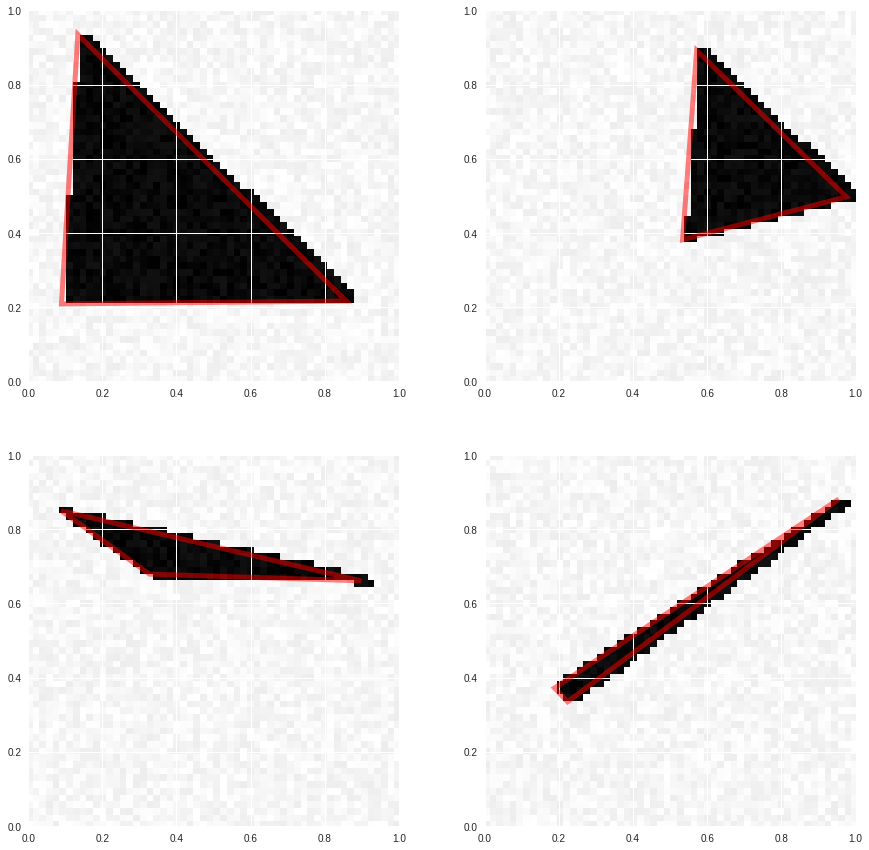

In [86]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
X_train = X_train.reshape((X_train.shape[0], 72, 72, 1))
Y_train = sort_vertices(Y_train)
visualize_prediction(X_train, Y_train, 2, 2)



Train on 2700 samples, validate on 300 samples
Epoch 1/500
2700/2700 [==============================] - 3s 1ms/step - loss: 0.0817 - val_loss: 0.0863
Epoch 2/500
2700/2700 [==============================] - 2s 708us/step - loss: 0.0427 - val_loss: 0.0713
Epoch 3/500
2700/2700 [==============================] - 2s 703us/step - loss: 0.0326 - val_loss: 0.0597
Epoch 4/500
2700/2700 [==============================] - 2s 705us/step - loss: 0.0277 - val_loss: 0.0480
Epoch 5/500
2700/2700 [==============================] - 2s 705us/step - loss: 0.0243 - val_loss: 0.0464
Epoch 6/500
2700/2700 [==============================] - 2s 698us/step - loss: 0.0217 - val_loss: 0.0393
Epoch 7/500
2700/2700 [==============================] - 2s 709us/step - loss: 0.0192 - val_loss: 0.0377
Epoch 8/500
2700/2700 [==============================] - 2s 705us/step - loss: 0.0172 - val_loss: 0.0352
Epoch 9/500
2700/2700 [==============================] - 2s 710us/step - loss: 0.0156 - val_loss: 0.0256
Epoch 10/5

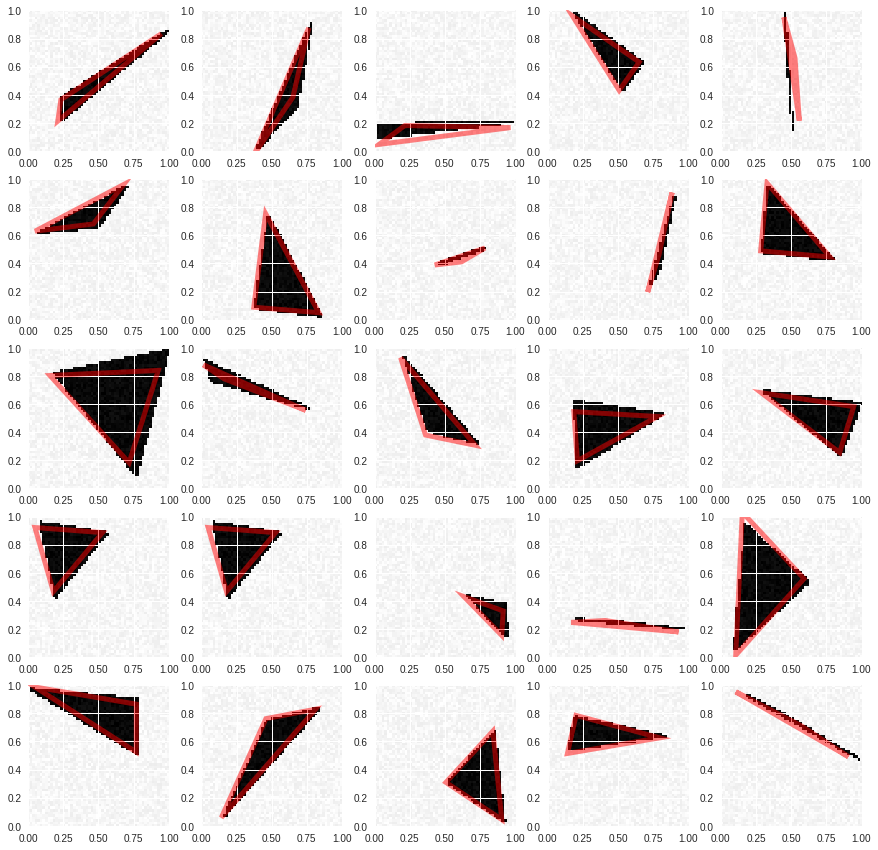

In [88]:
adam=Adam(0.0005)

model = Sequential([Conv2D(60, (3, 3), activation='relu',input_shape=(72, 72, 1)),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.15),
                    
                    Conv2D(40, (3, 3), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.15),
                    
                    Conv2D(40, (3, 3), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.25),
                    
                    Conv2D(20, (3, 3), activation='relu'),
                    
                    Flatten(),
                    Dense(6)])

model.compile(loss='mean_squared_error',optimizer=adam)#, metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=500, validation_split=0.1,  batch_size=32)


[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape((X_test.shape[0], 72, 72, 1))
Y_test = sort_vertices(Y_test)
print("\n\n\n==== Error on the test set ====\n\n",model.evaluate(X_test, Y_test))

visualize_prediction(X_test, model.predict(X_test), 5, 5)

## Image Denoising

** Comment : ** we use a simple denoising encoder, with three convolutional layers, with a max-pooling module and a dropout between the first and the second convolutional layers and with an upsampling module and a dropout between the second and third convolutional layers, before a final convolutional layer which yields the hopefully denoised image. We use 3000 examples, 250 epochs, the binary cross-entropy loss and the same Adam optimizer as before. As a result, we obtain a loss close to -3173.37 on the testing set and we manage to retrieve the denoised images pretty well.

In [0]:
# Rewriting the functions to return an image with a noise and an image without noise

IMAGE_SIZE = 72

def generate_a_drawing_denoising(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_denoising(figsize, U, V, noise)


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_denoising(figsize, U, V, noise)

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata_noise, im_data = generate_a_drawing_denoising(figsize, U, V, noise)
    return [imdata_noise, im_data, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_denoising()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        noise = np.random.uniform(15.,40.)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_denoising(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle_denoising(noise, free_location)
    return [X, Y]

def generate_test_set_denoising(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, free_location)
    return [X_test, Y_test]


import matplotlib.patches as patches

def visualize_prediction_denoising(x, y, num_rows=1):
    fig, ax = plt.subplots(figsize=(15, 15), nrows=num_rows, ncols = 2)
    
    indices = np.random.randint(0, x.shape[0], size=num_rows)
    
    for row in range(num_rows):
    
        I = x[indices[row]].reshape((IMAGE_SIZE,IMAGE_SIZE))
        ax[row,0].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
        ax[row,0].set_xlim([0,1])
        ax[row,0].set_ylim([0,1])
        
        J = y[indices[row]].reshape((IMAGE_SIZE,IMAGE_SIZE))
        ax[row,1].imshow(J, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
        ax[row,1].set_xlim([0,1])
        ax[row,1].set_ylim([0,1])

    plt.show()



Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


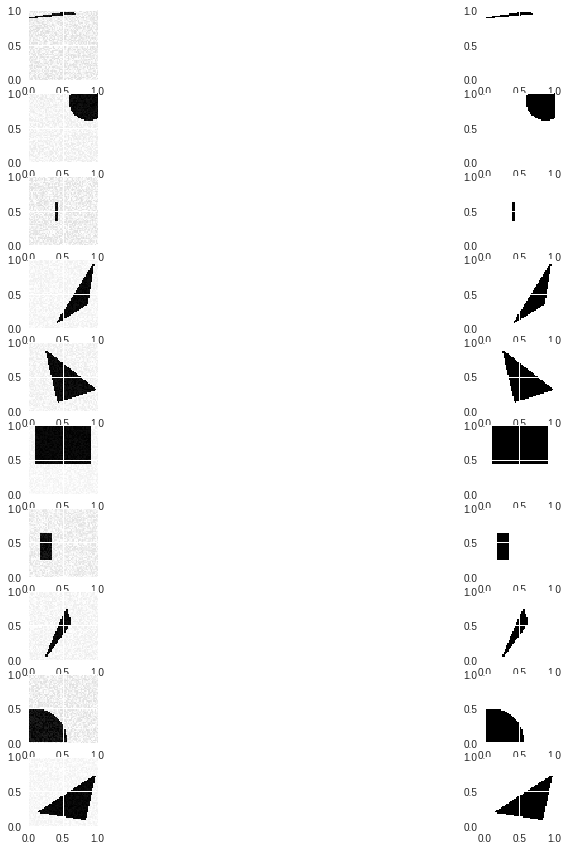

In [70]:
# Create data and visualize it

X_train, Y_train = generate_dataset_denoising(3000, free_location=True)
X_train = X_train.reshape((3000,72,72,1))
Y_train = Y_train.reshape((3000,72,72,1))
visualize_prediction_denoising(X_train, Y_train, num_rows=10)

In [76]:

l1reg = regularizers.l1(1e-6)

model = Sequential([Conv2D(40, (3,3), activation='relu', input_shape=(72,72,1), padding='same', strides=(1,1), activity_regularizer=l1reg),
                    MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2,2)),
                    Dropout(0.15),

                    Conv2D(40, (3,3), activation='relu', input_shape=(72,72,1), padding='same', strides=(1,1), activity_regularizer=l1reg),
                    
                    Dropout(0.15),
                    UpSampling2D((2,2)),
                    Conv2D(40, (3,3), activation='relu', input_shape=(72,72,1), padding='same', strides=(1,1), activity_regularizer=l1reg),
                    
                    Conv2D(1, (3,3), activation='sigmoid', padding='same', strides=(1,1))])

model.compile(loss='binary_crossentropy',optimizer=adam)
model.fit(X_train, Y_train, epochs=250, validation_split=0.1,  batch_size=32)

Train on 2700 samples, validate on 300 samples
Epoch 1/250
2700/2700 [==============================] - 6s 2ms/step - loss: -3519.8117 - val_loss: -3640.5215
Epoch 2/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3666.2107 - val_loss: -3646.2105
Epoch 3/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3666.8588 - val_loss: -3647.8581
Epoch 4/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3670.2385 - val_loss: -3649.1596
Epoch 5/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3667.2271 - val_loss: -3649.4167
Epoch 6/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3671.4102 - val_loss: -3650.0988
Epoch 7/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3672.4742 - val_loss: -3650.9740
Epoch 8/250
2700/2700 [==============================] - 5s 2ms/step - loss: -3673.1479 - val_loss: -3651.7320
Epoch 9/250
2700/2700 [==============================] - 5s 2ms/s

Creating data:
0
100
200
300/300 [==============================] - 0s 650us/step



==== Error on the test set ====

 -3173.3701529947916


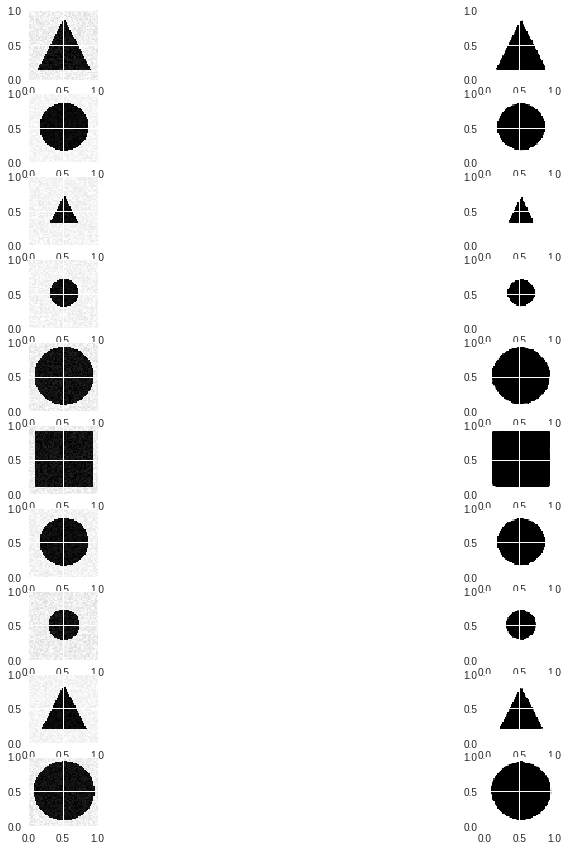

In [80]:
[X_test, Y_test] = generate_test_set_denoising()
X_test = X_test.reshape((X_test.shape[0], 72, 72, 1))
Y_test = Y_test.reshape((Y_test.shape[0], 72, 72, 1))
print("\n\n\n==== Error on the test set ====\n\n",model.evaluate(X_test, Y_test))
visualize_prediction_denoising(X_test, model.predict(X_test), 10)